<h2
    style="font-size:20px; font-family:'Helvetica Neue'" align="right"> Viktor Trokhymenko 
</h2>
<h3 
    style="font-size:16px; font-family:'Helvetica Neue'" align="right"> @vtrokhymenko
</h3>

In [193]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.random.seed(42)
import re
from pprint import pprint
import ast

import matplotlib.pyplot as plt
%matplotlib inline

In [194]:
import scipy.sparse as ss
from sklearn.feature_extraction.text import CountVectorizer

# https://github.com/gregversteeg/corex_topic
from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

import _pickle as cPickle
import pickle

---

In [3]:
%%time

df=pd.read_csv('data/news_lenta_pymorphy.csv.zip')
print(df.shape)

(699777, 3)
CPU times: user 22.3 s, sys: 1.95 s, total: 24.2 s
Wall time: 24.7 s


In [4]:
%%time

# приведем поле `text_pymorphy` к `literal_eval`
df['text_pymorphy'] = df.text_pymorphy.apply(lambda x: ast.literal_eval(x))

# подсчитаем к-ство токенов для каждой записи
df['len'] = df.text_pymorphy.apply(lambda x: len(x))

# оставим где к-ство токенов >3 для каждого дока (но тут нужно еще подумать)
df = df[df.len > 3]

CPU times: user 2min 44s, sys: 26.8 s, total: 3min 10s
Wall time: 3min 18s


In [5]:
%%time

# джойним лист, для дальнейшей работы
df['text_join'] = df.text_pymorphy.apply(lambda x: ' '.join(x))

CPU times: user 13.5 s, sys: 50 s, total: 1min 3s
Wall time: 1min 20s


In [6]:
# объединим год и месяц, добавляя статическую дату
# это делается для последующей визуализации

def prepare_date2vis(year,month,day=11):
    if len(str(month))==2:
        return str(int(year))+'-'+str(int(month))+'-'+str(day)
    else:
        return str(int(year))+'-0'+str(int(month))+'-'+str(day)

print(prepare_date2vis(2018,8))
print(prepare_date2vis(2018,12))

2018-08-11
2018-12-11


In [7]:
%%time
df['date'] = df.apply(lambda x: prepare_date2vis(x.year, x.month), axis=1)

CPU times: user 16.9 s, sys: 210 ms, total: 17.2 s
Wall time: 17.3 s


In [8]:
# как мы знаем, то в этом датасете есть 1914 год
# мы его дропаем
df = df[df.year != 1914]

# добавляем `docID` чтобы потом смерждить по этому полю
df['docID'] = [i for i in range(df.shape[0])]

In [9]:
# смотрим что получилось
print(df.shape)
df.head(3)

(699484, 7)


,year,month,text_pymorphy,len,text_join,date,docID
0,2018,7,"[украинский, боксёр, александр, усик, рассказа...",111,украинский боксёр александр усик рассказать ра...,2018-07-11,0
1,2018,7,"[израиль, эвакуировать, сирия, активист, белых...",89,израиль эвакуировать сирия активист белых каск...,2018-07-11,1
2,2018,7,"[лондонский, челси, отказаться, продать, мадри...",89,лондонский челси отказаться продать мадридский...,2018-07-11,2


---

### CountVectorizer

In [10]:
%%time

# делаем мешок слов
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(df.text_join)

# делаем спарс-матрцу
doc_word = ss.csr_matrix(doc_word)

print(doc_word.shape)  # n_docs x m_words

(699484, 556556)
CPU times: user 1min 23s, sys: 7.22 s, total: 1min 31s
Wall time: 1min 34s


699489 документов с 556574 словами

In [11]:
%%time

# получаем слова
words = list(np.asarray(vectorizer.get_feature_names()))

# удаляем целые числа
not_digit_inds = [ind for ind, word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:, not_digit_inds]
words = [word for ind, word in enumerate(words) if not word.isdigit()]

print(doc_word.shape)  # n_docs x m_words

(699484, 556556)
CPU times: user 9.09 s, sys: 1.01 s, total: 10.1 s
Wall time: 10.3 s


In [12]:
print(words[:10])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaab', 'aaab', 'aaae', 'aaariess', 'aaas']


## CorEx Topic Model

The main parameters of the CorEx topic model are:
* **n_hidden:** number of topics ("hidden" as in "hidden latent topics")
* **words:** words that label the columns of the doc-word matrix (optional)
* **docs:** document labels that label the rows of the doc-word matrix (optional)
* **max_iter:** number of iterations to run through the update equations (optional, defaults to 200)
* **verbose:** if verbose=1, then CorEx will print the topic TCs with each iteration
* **seed:** random number seed to use for model initialization (optional)


In [196]:
# задаем к-ство топиков (для примера взял 50)
NUM_TOPICS = 50

In [197]:
%%time
topic_model = ct.Corex(n_hidden=NUM_TOPICS,
                       words=words,
                       max_iter=333,
                       verbose=0,
                       seed=1)
topic_model.fit(doc_word, words=words)

CPU times: user 2h 40min 11s, sys: 51min 27s, total: 3h 31min 38s
Wall time: 3h 32min 4s


### topics

In [200]:
# посмотрим что отнеслось к 1 топику
topic_model.get_topics(topic=1, n_words=10)

[('фильм', 0.11684887247220253),
 ('режиссёр', 0.0722864455180042),
 ('картина', 0.05844150408481771),
 ('актёр', 0.05545499385447209),
 ('роль', 0.042661200164971276),
 ('музыкант', 0.038817090786270256),
 ('премия', 0.0359106496433379),
 ('альбом', 0.03469298343556512),
 ('прокат', 0.029908114052653402),
 ('песня', 0.02826296220278862)]

In [201]:
# получим индексы столбцов
topic_model.get_topics(topic=1, n_words=10, print_words=False)

[(507776, 0.11684887247220253),
 (433667, 0.0722864455180042),
 (292235, 0.05844150408481771),
 (164791, 0.05545499385447209),
 (438991, 0.042661200164971276),
 (356860, 0.038817090786270256),
 (416238, 0.0359106496433379),
 (167031, 0.03469298343556512),
 (420587, 0.029908114052653402),
 (400555, 0.02826296220278862)]

In [202]:
# посмотрим все топики
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: матч,чемпионат,команда,сборный,клуб,турнир,чемпион,тренер,игра,сборная
1: фильм,режиссёр,картина,актёр,роль,музыкант,премия,альбом,прокат,песня
2: пользователь,сервис,интернет,разработчик,сеть,выпустить,google,смартфон,компьютер,apple
3: погибнуть,произойти,человек,ранение,происшествие,пострадать,район,результат,взрыв,пострадавший
4: учёный,исследователь,исследование,журнал,университет,земля,поверхность,nature,астроном,планета
5: самолёт,борт,полёт,экипаж,авиакомпания,рейс,корабль,воздушный,пассажир,аэропорт
6: процент,рост,вырасти,показатель,снижение,сравнение,уровень,экономика,снизиться,объесть
7: аль,израиль,ирак,израильский,сирия,палестинский,иракский,оон,сирийский,иран
8: уголовный,дело,возбудить,задержать,следствие,следственный,правоохранительный,орган,статья,прокуратура
9: суд,приговорить,адвокат,иск,судебный,лишение,приговор,виновный,признать,свобода
10: доллар,миллиард,рубль,миллион,сумма,финансовый,банка,деньга,банк,бюджет
11: the,сша,американский,press,штат,associated,бри

In [203]:
# получим доступ к топику что присвоилось для каждого слова
print(topic_model.clusters.shape) # m_words
print(topic_model.clusters)

(556556,)
[ 6  6  2 ... 14  2 39]


### document labels

In [204]:
# документы сортируются с логарифмической вероятностью, к примеру [e^0=1,e^(-0,5)=0,6]
topic_model.get_top_docs(topic=1, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(580015, 0.0),
 (41338, 0.0),
 (392981, 0.0),
 (393000, 0.0),
 (509746, 0.0),
 (393017, 0.0),
 (166971, 0.0),
 (166969, 0.0),
 (166966, 0.0),
 (634037, 0.0)]

CorEx is a discriminative model, whereas LDA is a generative model.

In [205]:
# получим оценочные вероятности тем для каждого документа
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(699484, 50)


In [206]:
topic_model.p_y_given_x

array([[9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.56913708e-03, 8.49613203e-03, 4.10159618e-02],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.56693126e-03, 9.76281994e-03, 4.13889498e-02],
       [9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.56620894e-03, 8.96125883e-03, 3.10456349e-01],
       ...,
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.56580468e-03, 9.87647398e-03, 9.90734288e-01],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.57421407e-03, 2.87857202e-02, 3.92462359e-02],
       [1.00000000e-06, 1.00000000e-06, 2.66465983e-06, ...,
        2.57602894e-03, 9.15072489e-03, 8.19656839e-02]])

In [207]:
# также можно и юзать softmax для двоичного определения (какие документы принадлежат для каждой темы)
print(topic_model.labels.shape) # n_docs x k_topics

(699484, 50)


In [208]:
topic_model.labels

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Total Correlation and Model Selection

* Overall TC

при построении topic modelling, CorEx максимизирует меру total correlation

In [209]:
topic_model.tc

43.629974315085796

**Model selection**: CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

* Topic TC

обобщенная корреляция - это сумма общей корреляции по каждой из тем.

Для unsupervised CorEx темы всегда сортируются от высокого к низкому согласно с их TC

In [210]:
topic_model.tcs.shape # k_topics

(50,)

In [211]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

43.629974315085796
43.629974315085796


_Selecting number of topics_:

один из способов - наблюдать за распределением TCs на каждой эпохе, чтобы видеть какой дополнительный топик вносит вклад в общий TC

добавляем топики пока дополнительный топики не будут делать существенное вложение с общий TC

это похоже на выбор обрезания собственного значения при topic modeling через lsa

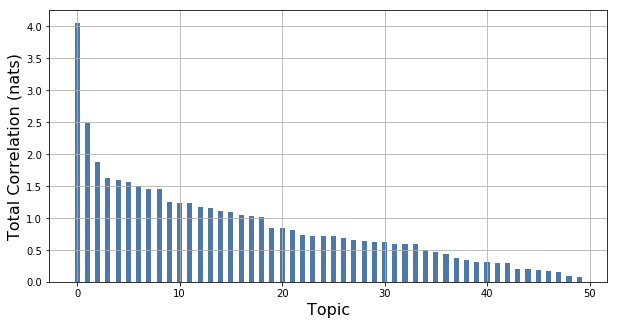

In [212]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]),
        topic_model.tcs,
        color='#4e79a7',
        width=0.5)
plt.grid()
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

как видно с графика, 1й топик наиболее информативнее

### Pointwise Document TC

В дальнейшем можна разложить total correlation - это среднее значение точечных [pointwise] общих корреляций для каждого отдельного документа

In [213]:
topic_model.log_z.shape # n_docs x k_topics

(699484, 50)

In [214]:
print(np.mean(topic_model.log_z, axis=0))
print('\n',topic_model.tcs)

[4.05025458 2.48910466 1.86701943 1.63002257 1.5912133  1.55844019
 1.50273486 1.4509083  1.44994655 1.25278516 1.23741579 1.22618381
 1.16827247 1.16076602 1.10249867 1.08622457 1.03769031 1.02612718
 1.00710483 0.84163278 0.83426515 0.81788102 0.73484154 0.71896774
 0.7147631  0.71295179 0.68224749 0.6509134  0.63092663 0.62434833
 0.6166213  0.59385937 0.59216293 0.58775332 0.49666713 0.46589996
 0.4334826  0.3799848  0.33455505 0.30681642 0.30444114 0.28940736
 0.28731925 0.19939036 0.19838173 0.18535431 0.17675509 0.1512858
 0.09199489 0.07938926]

 [4.05025458 2.48910466 1.86701943 1.63002257 1.5912133  1.55844019
 1.50273486 1.4509083  1.44994655 1.25278516 1.23741579 1.22618381
 1.16827247 1.16076602 1.10249867 1.08622457 1.03769031 1.02612718
 1.00710483 0.84163278 0.83426515 0.81788102 0.73484154 0.71896774
 0.7147631  0.71295179 0.68224749 0.6509134  0.63092663 0.62434833
 0.6166213  0.59385937 0.59216293 0.58775332 0.49666713 0.46589996
 0.4334826  0.3799848  0.33455505 0.3

`log_z` представляет собой корреляцию внутри отдельного дока объясненный конкретной темой. Использовалася для измерения, насколько "супрайзинг" документы относятся к данным темам

### Hierarchical Topic Models

атрибуты лэйблов дают двоичные выражения топика для каждого дока и топика. и этот выход мы можем использовать для входа другой модели CorEx topic model, чтобы получить латентное представление самих тем

по 1й слою можно определить к-во скрытых латентных переменных для добавления в высшие слои, изучив TCs 

In [215]:
%%time
# Train a second layer to the topic model
# в `n_hidden` задается к скольки топикам мы хотим ужать в этом слое
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

CPU times: user 2min 33s, sys: 1min 45s, total: 4min 18s
Wall time: 2min 42s


In [216]:
%%time
# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

CPU times: user 12.1 s, sys: 1.31 s, total: 13.4 s
Wall time: 11.3 s


In [224]:

import numpy as np  # Tested with 1.8.0
from os import makedirs
from os import path
from scipy.misc import logsumexp  # Tested with 0.13.0
import scipy.sparse as ss
from six import string_types # For Python 2&3 compatible string checking
from sklearn.externals import joblib


class Corex(object):
    """
    Anchored CorEx hierarchical topic models
    Code follows sklearn naming/style (e.g. fit(X) to train)

    Parameters
    ----------
    n_hidden : int, optional, default=2
        Number of hidden units.

    max_iter : int, optional
        Maximum number of iterations before ending.

    verbose : int, optional
        The verbosity level. The default, zero, means silent mode. 1 outputs TC(X;Y) as you go
        2 output alpha matrix and MIs as you go.

    tree : bool, default=True
        In a tree model, each word can only appear in one topic. tree=False is not yet implemented.

    count : string, {'binarize', 'fraction'}
        Whether to treat counts (>1) by directly binarizing them, or by constructing a fractional count in [0,1].

    seed : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.

    Attributes
    ----------
    labels : array, [n_samples, n_hidden]
        Label for each hidden unit for each sample.

    clusters : array, [n_visible]
        Cluster label for each input variable.

    p_y_given_x : array, [n_samples, n_hidden]
        p(y_j=1|x) for each sample.

    alpha : array-like, shape [n_hidden, n_visible]
        Adjacency matrix between input variables and hidden units. In range [0,1].

    mis : array, [n_hidden, n_visible]
        Mutual information between each (visible/observed) variable and hidden unit

    tcs : array, [n_hidden]
        TC(X_Gj;Y_j) for each hidden unit

    tc : float
        Convenience variable = Sum_j tcs[j]

    tc_history : array
        Shows value of TC over the course of learning. Hopefully, it is converging.

    words : list of strings
        Feature names that label the corresponding columns of X

    References
    ----------

    [1]     Greg Ver Steeg and Aram Galstyan. "Discovering Structure in
            High-Dimensional Data Through Correlation Explanation."
            NIPS, 2014. arXiv preprint arXiv:1406.1222.

    [2]     Greg Ver Steeg and Aram Galstyan. "Maximally Informative
            Hierarchical Representations of High-Dimensional Data"
            AISTATS, 2015. arXiv preprint arXiv:1410.7404.

    """

    def __init__(self, n_hidden=2, max_iter=200, eps=1e-5, seed=None, verbose=False, count='binarize',
                 tree=True, **kwargs):
        self.n_hidden = n_hidden  # Number of hidden factors to use (Y_1,...Y_m) in paper
        self.max_iter = max_iter  # Maximum number of updates to run, regardless of convergence
        self.eps = eps  # Change to signal convergence
        self.tree = tree
        np.random.seed(seed)  # Set seed for deterministic results
        self.verbose = verbose
        self.t = 20  # Initial softness of the soft-max function for alpha (see NIPS paper [1])
        self.count = count  # Which strategy, if necessary, for binarizing count data
        if verbose > 0:
            np.set_printoptions(precision=3, suppress=True, linewidth=200)
            print('corex, rep size:', n_hidden)
        if verbose:
            np.seterr(all='warn')
            # Can change to 'raise' if you are worried to see where the errors are
            # Locally, I "ignore" underflow errors in logsumexp that appear innocuous (probabilities near 0)
        else:
            np.seterr(all='ignore')

    def label(self, p_y_given_x):
        """Maximum likelihood labels for some distribution over y's"""
        return (p_y_given_x > 0.5).astype(bool)

    @property
    def labels(self):
        """Maximum likelihood labels for training data. Can access with self.labels (no parens needed)"""
        return self.label(self.p_y_given_x)

    @property
    def clusters(self):
        """Return cluster labels for variables"""
        return np.argmax(self.alpha, axis=0)

    @property
    def sign(self):
        """Return the direction of correlation, positive or negative, for each variable-latent factor."""
        return np.sign(self.theta[3] - self.theta[2]).T

    @property
    def tc(self):
        """The total correlation explained by all the Y's.
        """
        return np.sum(self.tcs)

    def fit(self, X, anchors=None, anchor_strength=1, words=None, docs=None):
        """
        Fit CorEx on the data X. See fit_transform.
        """
        self.fit_transform(X, anchors=anchors, anchor_strength=anchor_strength, words=words, docs=docs)
        return self

    def fit_transform(self, X, anchors=None, anchor_strength=1, words=None, docs=None):
        """Fit CorEx on the data

        Parameters
        ----------
        X : scipy sparse CSR or a numpy matrix, shape = [n_samples, n_visible]
            Count data or some other sparse binary data.

        anchors : A list of variables anchor each corresponding latent factor to.

        anchor_strength : How strongly to weight the anchors.

        words : list of strings that label the corresponding columns of X

        docs : list of strings that label the corresponding rows of X

        Returns
        -------
        Y: array-like, shape = [n_samples, n_hidden]
           Learned values for each latent factor for each sample.
           Y's are sorted so that Y_1 explains most correlation, etc.
        """
        X = self.preprocess(X)
        self.initialize_parameters(X, words, docs)
        if anchors is not None:
            anchors = self.preprocess_anchors(list(anchors))
        p_y_given_x = np.random.random((self.n_samples, self.n_hidden))
        if anchors is not None:
            for j, a in enumerate(anchors):
                p_y_given_x[:, j] = 0.5 * p_y_given_x[:, j] + 0.5 * X[:, a].mean(axis=1).A1  # Assumes X is a binary matrix

        for nloop in range(self.max_iter):
            if nloop > 1:
                for j in range(self.n_hidden):
                    if self.sign[j, np.argmax(self.mis[j])] < 0:
                        # Switch label for Y_j so that it is correlated with the top word
                        p_y_given_x[:, j] = 1. - p_y_given_x[:, j]
            self.log_p_y = self.calculate_p_y(p_y_given_x)
            self.theta = self.calculate_theta(X, p_y_given_x, self.log_p_y)  # log p(x_i=1|y)  nv by m by k

            if nloop > 0:  # Structure learning step
                self.alpha = self.calculate_alpha(X, p_y_given_x, self.theta, self.log_p_y, self.tcs)
            if anchors is not None:
                for a in flatten(anchors):
                    self.alpha[:, a] = 0
                for ia, a in enumerate(anchors):
                    self.alpha[ia, a] = anchor_strength

            p_y_given_x, _, log_z = self.calculate_latent(X, self.theta)

            self.update_tc(log_z)  # Calculate TC and record history to check convergence
            self.print_verbose()
            if self.convergence():
                break

        if self.verbose:
            print('Overall tc:', self.tc)

        if anchors is None:
            self.sort_and_output(X)
        self.p_y_given_x, self.log_p_y_given_x, self.log_z = self.calculate_latent(X, self.theta)  # Needed to output labels
        self.mis = self.calculate_mis(self.theta, self.log_p_y)  # / self.h_x  # could normalize MIs
        return self.labels

    def transform(self, X, details=False):
        """
        Label hidden factors for (possibly previously unseen) samples of data.
        Parameters: samples of data, X, shape = [n_samples, n_visible]
        Returns: , shape = [n_samples, n_hidden]
        """
        X = self.preprocess(X)
        p_y_given_x, _, log_z = self.calculate_latent(X, self.theta)
        labels = self.label(p_y_given_x)
        if details == 'surprise':
            # TODO: update
            # Totally experimental
            n_samples = X.shape[0]
            alpha = np.zeros((self.n_hidden, self.n_visible))
            for i in range(self.n_visible):
                alpha[np.argmax(self.alpha[:, i]), i] = 1
            log_p = np.empty((2, n_samples, self.n_hidden))
            c0 = np.einsum('ji,ij->j', alpha, self.theta[0])
            c1 = np.einsum('ji,ij->j', alpha, self.theta[1])  # length n_hidden
            info0 = np.einsum('ji,ij->ij', alpha, self.theta[2] - self.theta[0])
            info1 = np.einsum('ji,ij->ij', alpha, self.theta[3] - self.theta[1])
            log_p[1] = c1 + X.dot(info1)  # sum_i log p(xi=xi^l|y_j=1)  # Shape is 2 by l by j
            log_p[0] = c0 + X.dot(info0)  # sum_i log p(xi=xi^l|y_j=0)
            surprise = [-np.sum([log_p[labels[l, j], l, j] for j in range(self.n_hidden)]) for l in range(n_samples)]
            return p_y_given_x, log_z, np.array(surprise)
        elif details:
            return p_y_given_x, log_z
        else:
            return labels

    def predict_proba(self, X):
        return self.transform(X, details=True)

    def predict(self, X):
        return self.transform(X, details=False)

    def preprocess(self, X):
        """Data can be binary or can be in the range [0,1], where that is interpreted as the probability to
        see this variable in a given sample"""
        if X.max() > 1:
            if self.count == 'binarize':
                X = (X > 0)
            elif self.count == 'fraction':
                X = X.astype(float)
                count = np.array(X.sum(axis=0), dtype=float).ravel()
                length = np.array(X.sum(axis=1)).ravel().clip(1)
                bg_rate = ss.diags(float(X.sum()) / count, 0)
                doc_length = ss.diags(1. / length, 0)
                # max_counts = ss.diags(1. / X.max(axis=1).A.ravel(), 0)
                X = doc_length * X * bg_rate
                X.data = np.clip(X.data, 0, 1)  # np.log(X.data) / (np.log(X.data) + 1)
        return X

    def initialize_parameters(self, X, words, docs):
        """Store some statistics about X for future use, and initialize alpha, tc"""
        self.n_samples, self.n_visible = X.shape
        if self.n_hidden > 1:
            self.alpha = np.random.random((self.n_hidden, self.n_visible))
            # self.alpha /= np.sum(self.alpha, axis=0, keepdims=True)
        else:
            self.alpha = np.ones((self.n_hidden, self.n_visible), dtype=float)
        self.tc_history = []
        self.tcs = np.zeros(self.n_hidden)
        self.word_counts = np.array(
            X.sum(axis=0)).ravel()  # 1-d array of total word occurrences. (Probably slow for CSR)
        if np.any(self.word_counts == 0) or np.any(self.word_counts == self.n_samples):
            print('WARNING: Some words never appear (or always appear)')
            self.word_counts = self.word_counts.clip(0.01, self.n_samples - 0.01)
        self.word_freq = (self.word_counts).astype(float) / self.n_samples
        self.px_frac = (np.log1p(-self.word_freq) - np.log(self.word_freq)).reshape((-1, 1))  # nv by 1
        self.lp0 = np.log1p(-self.word_freq).reshape((-1, 1))  # log p(x_i=0)
        self.h_x = binary_entropy(self.word_freq)
        if self.verbose:
            print('word counts', self.word_counts)
        # Set column labels
        self.words = words
        if words is not None:
            if len(words) != X.shape[1]:
                print('WARNING: number of column labels != number of columns of X. Check len(words) and X.shape[1]')
            col_index2word = {index:word for index,word in enumerate(words)}
            word2col_index = {word:index for index,word in enumerate(words)}
            self.col_index2word = col_index2word
            self.word2col_index = word2col_index
        else:
            self.col_index2word = None
            self.word2col_index = None
        # Set row labels
        self.docs = docs
        if docs is not None:
            if len(docs) != X.shape[0]:
                print('WARNING: number of row labels != number of rows of X. Check len(docs) and X.shape[0]')
            row_index2doc = {index:doc for index,doc in enumerate(docs)}
            self.row_index2doc = row_index2doc
        else:
            self.row_index2doc = None

    def update_word_parameters(self, X, words):
        """
        updates parameters that need to be changed for each new model update
        specifically, this re-calculates word count related parameters to be based on X,
        where X is a batch of new data
        """
        self.n_samples, self.n_visible = X.shape
        self.word_counts = np.array(
            X.sum(axis=0)).ravel()  # 1-d array of total word occurrences. (Probably slow for CSR)
        if np.any(self.word_counts == 0) or np.any(self.word_counts == self.n_samples):
            print('WARNING: Some words never appear (or always appear)')
            self.word_counts = self.word_counts.clip(0.01, self.n_samples - 0.01)
        self.word_freq = (self.word_counts).astype(float) / self.n_samples
        self.px_frac = (np.log1p(-self.word_freq) - np.log(self.word_freq)).reshape((-1, 1))  # nv by 1
        self.lp0 = np.log1p(-self.word_freq).reshape((-1, 1))  # log p(x_i=0)
        self.h_x = binary_entropy(self.word_freq)
        if self.verbose:
            print('word counts', self.word_counts)
        self.words = words
        if words is not None:
            if len(words) != X.shape[1]:
                print('WARNING: number of column labels != number of columns of X. Check len(words) and X.shape[1]')
            col_index2word = {index:word for index,word in enumerate(words)}
            word2col_index = {word:index for index,word in enumerate(words)}
            self.col_index2word = col_index2word
            self.word2col_index = word2col_index
        else:
            self.col_index2word = None
            self.word2col_index = None

    def preprocess_anchors(self, anchors):
        """Preprocess anchors so that it is a list of column indices if not already"""
        if anchors is not None:
            for n, anchor_list in enumerate(anchors):
                # Check if list of anchors or a single str or int anchor
                if type(anchor_list) is not list:
                    anchor_list = [anchor_list]
                # Convert list of anchors to list of anchor indices
                new_anchor_list = []
                for anchor in anchor_list:
                    # Turn string anchors into index anchors
                    if isinstance(anchor, string_types):
                        if self.words is not None:
                            if anchor in self.word2col_index:
                                new_anchor_list.append(self.word2col_index[anchor])
                            else:
                                raise KeyError('Anchor word not in word column labels provided to CorEx: {}'.format(anchor))
                        else:
                                raise NameError("Provided non-index anchors to CorEx without also providing 'words'")
                    else:
                        new_anchor_list.append(anchor)
                # Update anchors with new anchor list
                if len(new_anchor_list) == 1:
                    anchors[n] = new_anchor_list[0]
                else:
                    anchors[n] = new_anchor_list

        return anchors

    def calculate_p_y(self, p_y_given_x):
        """Estimate log p(y_j=1)."""
        return np.log(np.mean(p_y_given_x, axis=0))  # n_hidden, log p(y_j=1)

    def calculate_theta(self, X, p_y_given_x, log_p_y):
        """Estimate marginal parameters from data and expected latent labels."""
        # log p(x_i=1|y)
        n_samples = X.shape[0]
        p_dot_y = X.T.dot(p_y_given_x).clip(0.01 * np.exp(log_p_y), (n_samples - 0.01) * np.exp(
            log_p_y))  # nv by ns dot ns by m -> nv by m  # TODO: Change to CSC for speed?
        lp_1g1 = np.log(p_dot_y) - np.log(n_samples) - log_p_y
        lp_1g0 = np.log(self.word_counts[:, np.newaxis] - p_dot_y) - np.log(n_samples) - log_1mp(log_p_y)
        lp_0g0 = log_1mp(lp_1g0)
        lp_0g1 = log_1mp(lp_1g1)
        return np.array([lp_0g0, lp_0g1, lp_1g0, lp_1g1])  # 4 by nv by m

    def calculate_alpha(self, X, p_y_given_x, theta, log_p_y, tcs):
        """A rule for non-tree CorEx structure."""
        # TODO: Could make it sparse also? Well, maybe not... at the beginning it's quite non-sparse
        mis = self.calculate_mis(theta, log_p_y)
        if self.n_hidden == 1:
            alphaopt = np.ones((1, self.n_visible))
        elif self.tree:
            # sa = np.sum(self.alpha, axis=0)
            tc_oom = 1. / self.n_samples
            sa = np.sum(self.alpha[tcs > tc_oom], axis=0)
            self.t = np.where(sa > 1.1, 1.3 * self.t, self.t)
            # tc_oom = np.median(self.h_x)  # \propto TC of a small group of corr. variables w/median entropy...
            # t = 20 + (20 * np.abs(tcs) / tc_oom).reshape((self.n_hidden, 1))  # worked well in many tests
            t = (1 + self.t * np.abs(tcs).reshape((self.n_hidden, 1)))
            maxmis = np.max(mis, axis=0)
            for i in np.where((mis == maxmis).sum(axis=0))[0]:  # Break ties for the largest MI
                mis[:, i] += 1e-10 * np.random.random(self.n_hidden)
                maxmis[i] = np.max(mis[:, i])
            with np.errstate(under='ignore'):
                alphaopt = np.exp(t * (mis - maxmis) / self.h_x)
        else:
            # TODO: Can we make a fast non-tree version of update in the AISTATS paper?
            alphaopt = np.zeros((self.n_hidden, self.n_visible))
            top_ys = np.argsort(-mis, axis=0)[:self.tree]
            raise NotImplementedError
        self.mis = mis  # So we don't have to recalculate it when used later
        return alphaopt

    def calculate_latent(self, X, theta):
        """"Calculate the probability distribution for hidden factors for each sample."""
        ns, nv = X.shape
        log_pygx_unnorm = np.empty((2, ns, self.n_hidden))
        c0 = np.einsum('ji,ij->j', self.alpha, theta[0] - self.lp0)
        c1 = np.einsum('ji,ij->j', self.alpha, theta[1] - self.lp0)  # length n_hidden
        info0 = np.einsum('ji,ij->ij', self.alpha, theta[2] - theta[0] + self.px_frac)
        info1 = np.einsum('ji,ij->ij', self.alpha, theta[3] - theta[1] + self.px_frac)
        log_pygx_unnorm[1] = self.log_p_y + c1 + X.dot(info1)
        log_pygx_unnorm[0] = log_1mp(self.log_p_y) + c0 + X.dot(info0)
        return self.normalize_latent(log_pygx_unnorm)

    def normalize_latent(self, log_pygx_unnorm):
        """Normalize the latent variable distribution

        For each sample in the training set, we estimate a probability distribution
        over y_j, each hidden factor. Here we normalize it. (Eq. 7 in paper.)
        This normalization factor is used for estimating TC.

        Parameters
        ----------
        Unnormalized distribution of hidden factors for each training sample.

        Returns
        -------
        p_y_given_x : 3D array, shape (n_hidden, n_samples)
            p(y_j|x^l), the probability distribution over all hidden factors,
            for data samples l = 1...n_samples
        log_z : 2D array, shape (n_hidden, n_samples)
            Point-wise estimate of total correlation explained by each Y_j for each sample,
            used to estimate overall total correlation.

        """
        with np.errstate(under='ignore'):
            log_z = logsumexp(log_pygx_unnorm, axis=0)  # Essential to maintain precision.
            log_pygx = log_pygx_unnorm[1] - log_z
            p_norm = np.exp(log_pygx)
        return p_norm.clip(1e-6, 1 - 1e-6), log_pygx, log_z  # ns by m

    def update_tc(self, log_z):
        self.tcs = np.mean(log_z, axis=0)
        self.tc_history.append(np.sum(self.tcs))

    def print_verbose(self):
        if self.verbose:
            print(self.tcs)
        if self.verbose > 1:
            print(self.alpha[:, :, 0])
            print(self.theta)

    def convergence(self):
        if len(self.tc_history) > 10:
            dist = -np.mean(self.tc_history[-10:-5]) + np.mean(self.tc_history[-5:])
            return np.abs(dist) < self.eps  # Check for convergence.
        else:
            return False

    def __getstate__(self):
        # In principle, if there were variables that are themselves classes... we have to handle it to pickle correctly
        # But I think I programmed around all that.
        self_dict = self.__dict__.copy()
        return self_dict

    def save(self, filename):
        """ Pickle a class instance. E.g., corex.save('saved.dat') """
        # Avoid saving words with object.
        #TODO: figure out why Unicode sometimes causes an issue with loading after pickling
        if self.words is not None:
            temp_words = self.words
            self.words = None
        else:
            temp_words = None
        # Save CorEx object
        import pickle
        if path.dirname(filename) and not path.exists(path.dirname(filename)):
            makedirs(path.dirname(filename))
        pickle.dump(self, open(filename, 'wb'), protocol=-1)
        # Restore words to CorEx object
        self.words = temp_words

    def save_joblib(self, filename):
        """ Serialize a class instance with joblib - better for larger models. E.g., corex.save('saved.dat') """
        # Avoid saving words with object.
        if self.words is not None:
            temp_words = self.words
            self.words = None
        else:
            temp_words = None
        # Save CorEx object
        if path.dirname(filename) and not path.exists(path.dirname(filename)):
            makedirs(path.dirname(filename))
        joblib.dump(self, filename)
        # Restore words to CorEx object
        self.words = temp_words

    def sort_and_output(self, X):
        order = np.argsort(self.tcs)[::-1]  # Order components from strongest TC to weakest
        self.tcs = self.tcs[order]  # TC for each component
        self.alpha = self.alpha[order]  # Connections between X_i and Y_j
        self.log_p_y = self.log_p_y[order]  # Parameters defining the representation
        self.theta = self.theta[:, :, order]  # Parameters defining the representation

    def calculate_mis(self, theta, log_p_y):
        """Return MI in nats, size n_hidden by n_variables"""
        p_y = np.exp(log_p_y).reshape((-1, 1))  # size n_hidden, 1
        mis = self.h_x - p_y * binary_entropy(np.exp(theta[3]).T) - (1 - p_y) * binary_entropy(np.exp(theta[2]).T)
        return (mis - 1. / (2. * self.n_samples)).clip(0.)  # P-T bias correction

    def get_topics(self, n_words=10, topic=None, print_words=True):
        """
        Return list of lists of tuples. Each list consists of the top words for a topic
        and each tuple is a pair (word, mutual information). If 'words' was not provided
        to CorEx, then 'word' will be an integer column index of X

        topic_n : integer specifying which topic to get (0-indexed)
        print_words : boolean, get_topics will attempt to print topics using
                      provided column labels (through 'words') if possible. Otherwise,
                      topics will be consist of column indices of X
        """
        # Determine which topics to iterate over
        if topic is not None:
            topic_ns = [topic]
        else:
            topic_ns = list(range(self.labels.shape[1]))
        # Determine whether to return column word labels or indices
        if self.words is None:
            print_words = False
            print("NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices")
        elif len(self.words) != self.alpha.shape[1]:
            print_words = False
            print('WARNING: number of column labels != number of columns of X. Cannot reliably add labels to topics. Check len(words) and X.shape[1]. Use .set_words() to fix')

        topics = [] # TODO: make this faster, it's slower than it should be
        for n in topic_ns:
            # Get indices of which words belong to the topic
            inds = np.where(self.alpha[n] >= 1.)[0]
            # Sort topic words according to mutual information
            inds = inds[np.argsort(-self.alpha[n,inds] * self.mis[n,inds])]
            # Create topic to return
            if print_words is True:
                topic = [(self.col_index2word[ind], self.sign[n,ind]*self.mis[n,ind]) for ind in inds[:n_words]]
            else:
                topic = [(ind, self.sign[n,ind]*self.mis[n,ind]) for ind in inds[:n_words]]
            # Add topic to list of topics if returning all topics. Otherwise, return topic
            if len(topic_ns) != 1:
                topics.append(topic)
            else:
                return topic

        return topics

    def get_top_docs(self, n_docs=10, topic=None, sort_by='log_prob', print_docs=True):
        """
        Return list of lists of tuples. Each list consists of the top docs for a topic
        and each tuple is a pair (doc, pointwise TC or probability). If 'docs' was not
        provided to CorEx, then each doc will be an integer row index of X

        topic_n : integer specifying which topic to get (0-indexed)
        sort_by: 'log_prob' or 'tc', use either 'log_p_y_given_x' or 'log_z' respectively
                 to return top docs per each topic
        print_docs : boolean, get_top_docs will attempt to print topics using
                     provided row labels (through 'docs') if possible. Otherwise,
                     top docs will be consist of row indices of X
        """
        # Determine which topics to iterate over
        if topic is not None:
            topic_ns = [topic]
        else:
            topic_ns = list(range(self.labels.shape[1]))
        # Determine whether to return row doc labels or indices
        if self.docs is None:
            print_docs = False
            print("NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices")
        elif len(self.docs) != self.labels.shape[0]:
            print_words = False
            print('WARNING: number of row labels != number of rows of X. Cannot reliably add labels. Check len(docs) and X.shape[0]. Use .set_docs() to fix')
        # Get appropriate matrix to sort
        if sort_by == 'log_prob':
            doc_values = self.log_p_y_given_x
        elif sort_by == 'tc':
            print('WARNING: sorting by logz not well tested')
            doc_values = self.log_z
        else:
            print("Invalid 'sort_by' parameter, must be 'prob' or 'tc'")
            return
        # Get top docs for each topic
        doc_inds = np.argsort(-doc_values, axis=0)
        top_docs = [] # TODO: make this faster, it's slower than it should be
        for n in topic_ns:
            if print_docs is True:
                topic_docs = [(self.row_index2doc[ind], doc_values[ind,n]) for ind in doc_inds[:n_docs,n]]
            else:
                topic_docs = [(ind, doc_values[ind,n]) for ind in doc_inds[:n_docs,n]]
            # Add docs to list of top docs per topic if returning all topics. Otherwise, return
            if len(topic_ns) != 1:
                top_docs.append(topic_docs)
            else:
                return topic_docs

        return top_docs

    def set_words(self, words):
        self.words = words
        if words is not None:
            if len(words) != self.alpha.shape[1]:
                print('WARNING: number of column labels != number of columns of X. Check len(words) and .alpha.shape[1]')
            col_index2word = {index:word for index,word in enumerate(words)}
            word2col_index = {word:index for index,word in enumerate(words)}
            self.col_index2word = col_index2word
            self.word2col_index = word2col_index

    def set_docs(self, docs):
        self.docs = docs
        if docs is not None:
            if len(docs) != self.labels.shape[0]:
                print('WARNING: number of row labels != number of rows of X. Check len(docs) and .labels.shape[0]')
            row_index2doc = {index:doc for index,doc in enumerate(docs)}
            self.row_index2doc = row_index2doc


def log_1mp(x):
    return np.log1p(-np.exp(x))


def binary_entropy(p):
    return np.where(p > 0, - p * np.log2(p) - (1 - p) * np.log2(1 - p), 0)


def flatten(a):
    b = []
    for ai in a:
        if type(ai) is list:
            b += ai
        else:
            b.append(ai)
    return b


def load(filename):
    """ Unpickle class instance. """
    import pickle
    return pickle.load(open(filename, 'rb'))


def load_joblib(filename):
    """ Load class instance with joblib. """
    return joblib.load(filename)


In [225]:
""" This module implements some visualizations based on CorEx representations.
"""

import os
from shutil import copyfile
import codecs
import numpy as np
import matplotlib
matplotlib.use('Agg') # to create visualizations on a display-less server
import pylab
import networkx as nx
import textwrap
import scipy.sparse as ss
import sklearn.feature_extraction.text as skt
#import cPickle, pickle # neither module is used, and cPickle is not part of Anaconda build, so commented for LF run
import corextopic as ct
import sys, traceback
from time import time
import re
import sklearn.feature_extraction.text as skt
from nltk.stem.snowball import *
pattern = '\\b[A-Za-z]+\\b'
np.seterr(all='ignore')


def vis_rep(corex, data=None, row_label=None, column_label=None, prefix='topics'):
    """Various visualizations and summary statistics for a one layer representation"""
    if column_label is None:
        column_label = list(map(str, range(data.shape[1])))
    if row_label is None:
        row_label = list(map(str, range(corex.n_samples)))

    alpha = corex.alpha

    print('Print topics in text file')
    output_groups(corex.tcs, alpha, corex.mis, column_label, corex.sign, prefix=prefix)
    output_labels(corex.labels, row_label, prefix=prefix)
    output_cont_labels(corex.p_y_given_x, row_label, prefix=prefix)
    output_strong(corex.tcs, alpha, corex.mis, corex.labels, prefix=prefix)
    anomalies(corex.log_z, row_label=row_label, prefix=prefix)
    plot_convergence(corex.tc_history, prefix=prefix)
    if data is not None:
        plot_heatmaps(data, alpha, corex.mis, column_label, corex.p_y_given_x, prefix=prefix)


def vis_hierarchy(corexes, column_label=None, max_edges=100, prefix='topics', n_anchors=0):
    """Visualize a hierarchy of representations."""
    if column_label is None:
        column_label = list(map(str, range(corexes[0].alpha.shape[1])))

    # make l1 label
    alpha = corexes[0].alpha
    mis = corexes[0].mis
    l1_labels = []
    annotate = lambda q, s: q if s > 0 else '~' + q

    print('n_hidden->',corexes[0].n_hidden)
    for j in range(corexes[0].n_hidden):
        # inds = np.where(alpha[j] * mis[j] > 0)[0]
        inds = np.where(alpha[j] >= 1.)[0]
        inds = inds[np.argsort(-alpha[j, inds] * mis[j, inds])]
        group_number = str('red_') + str(j) if j < n_anchors else str(j)
        label = group_number + ':' + ' '.join([annotate(column_label[ind], corexes[0].sign[j,ind]) for ind in inds[:6]])
        label = textwrap.fill(label, width=25)
        l1_labels.append(label)

    # Construct non-tree graph
    weights = [corex.alpha.clip(0, 1) * corex.mis for corex in corexes[1:]]
    node_weights = [corex.tcs for corex in corexes[1:]]
    g = make_graph(weights, node_weights, l1_labels, max_edges=max_edges)

    # Display pruned version
    h = g.copy()  # trim(g.copy(), max_parents=max_parents, max_children=max_children)
    edge2pdf(h, prefix + '/graphs/graph_prune_' + str(max_edges), labels='label', directed=True, makepdf=True)

    # Display tree version
    tree = g.copy()
    tree = trim(tree, max_parents=1, max_children=False)
    edge2pdf(tree, prefix + '/graphs/tree', labels='label', directed=True, makepdf=True)

    # Output JSON files
    try:
        import os
        #copyfile(os.path.dirname(os.path.realpath(__file__)) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
        copyfile(os.path.dirname(os.path.realpath('tests')) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
    except:
        print("Couldn't find 'force.html' file for visualizing d3 output")
    import json
    from networkx.readwrite import json_graph

    mapping = dict([(n, tree.node[n].get('label', str(n))) for n in tree.nodes()])
    tree = nx.relabel_nodes(tree, mapping)
    json.dump(json_graph.node_link_data(tree), safe_open(prefix + '/graphs/force.json', 'w+'))
    json.dump(json_graph.node_link_data(h), safe_open(prefix + '/graphs/force_nontree.json', 'w+'))

    return g


def plot_heatmaps(data, alpha, mis, column_label, cont, topk=40, athresh=0.2, prefix=''):
    import seaborn as sns
    cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
    import matplotlib.pyplot as plt
    m, nv = mis.shape
    for j in range(m):
        inds = np.where(np.logical_and(alpha[j] > athresh, mis[j] > 0.))[0]
        inds = inds[np.argsort(- alpha[j, inds] * mis[j, inds])][:topk]
        if len(inds) >= 2:
            plt.clf()
            order = np.argsort(cont[:,j])
            if type(data) == np.ndarray:
                subdata = data[:, inds][order].T
            else:
                # assume sparse
                subdata = data[:, inds].toarray()
                subdata = subdata[order].T
            columns = [column_label[i] for i in inds]
            fig, ax = plt.subplots(figsize=(20, 10))
            sns.heatmap(subdata, vmin=0, vmax=1, cmap=cmap, yticklabels=columns, xticklabels=False, ax=ax, cbar_kws={"ticks": [0, 0.5, 1]})
            plt.yticks(rotation=0)
            filename = '{}/heatmaps/group_num={}.png'.format(prefix, j)
            if not os.path.exists(os.path.dirname(filename)):
                os.makedirs(os.path.dirname(filename))
            plt.title("Latent factor {}".format(j))
            plt.savefig(filename, bbox_inches='tight')
            plt.close('all')
            #plot_rels(data[:, inds], map(lambda q: column_label[q], inds), colors=cont[:, j],
            #          outfile=prefix + '/relationships/group_num=' + str(j), latent=labels[:, j], alpha=0.1)


def make_graph(weights, node_weights, column_label, max_edges=100):
    all_edges = np.hstack(list(map(np.ravel, weights)))
    max_edges = min(max_edges, len(all_edges))
    w_thresh = np.sort(all_edges)[-max_edges]
    print('weight threshold is %f for graph with max of %f edges ' % (w_thresh, max_edges))
    g = nx.DiGraph()
    max_node_weight = max([max(w) for w in node_weights])
    for layer, weight in enumerate(weights):
        m, n = weight.shape
        for j in range(m):
            g.add_node((layer + 1, j))
            g.node[(layer + 1, j)]['weight'] = 0.3 * node_weights[layer][j] / max_node_weight
            for i in range(n):
                if weight[j, i] > w_thresh:
                    if weight[j, i] > w_thresh / 2:
                        g.add_weighted_edges_from([( (layer, i), (layer + 1, j), 10 * weight[j, i])])
                    else:
                        g.add_weighted_edges_from([( (layer, i), (layer + 1, j), 0)])

    # Label layer 0
    for i, lab in enumerate(column_label):
        g.add_node((0, i))
        g.node[(0, i)]['label'] = lab
        g.node[(0, i)]['name'] = lab  # JSON uses this field
        g.node[(0, i)]['weight'] = 1
    return g


def trim(g, max_parents=False, max_children=False):
    for node in g:
        if max_parents:
            parents = list(g.successors(node))
            #weights = [g.edge[node][parent]['weight'] for parent in parents]
            weights = [g.adj[node][parent]['weight'] for parent in parents]
            for weak_parent in np.argsort(weights)[:-max_parents]:
                g.remove_edge(node, parents[weak_parent])
        if max_children:
            children = g.predecessors(node)
            weights = [g.edge[child][node]['weight'] for child in children]
            for weak_child in np.argsort(weights)[:-max_children]:
                g.remove_edge(children[weak_child], node)
    return g


def output_groups(tcs, alpha, mis, column_label, direction, thresh=0, prefix=''):
    f = safe_open(prefix + '/groups.txt', 'w+')
    h = safe_open(prefix + '/topics.txt', 'w+')
    m, nv = mis.shape
    annotate = lambda q, s: q if s >= 0 else '~' + q
    for j in range(m):
        f.write('Group num: %d, TC(X;Y_j): %0.3f\n' % (j, tcs[j]))
        # inds = np.where(alpha[j] * mis[j] > thresh)[0]
        inds = np.where(alpha[j] >= 1.)[0]
        inds = inds[np.argsort(-alpha[j, inds] * mis[j, inds])]
        for ind in inds:
            f.write(column_label[ind] + u', %0.3f, %0.3f, %0.3f\n' % (
                mis[j, ind], alpha[j, ind], mis[j, ind] * alpha[j, ind]))
        #h.write(unicode(j) + u':' + u','.join([annotate(column_label[ind], direction[j,ind]) for ind in inds[:10]]) + u'\n')
        h.write(str(j) + u':' + u','.join(
            [annotate(column_label[ind], direction[j, ind]) for ind in inds[:10]]) + u'\n')
    f.close()
    h.close()


def output_labels(labels, row_label, prefix=''):
    f = safe_open(prefix + '/labels.txt', 'w+')
    ns, m = labels.shape
    for l in range(ns):
        f.write(row_label[l] + ',' + ','.join(list(map(lambda q: '%d' % q, labels[l, :])))+ '\n')
    f.close()


def output_cont_labels(p_y_given_x, row_label, prefix=''):
    f = safe_open(prefix + '/cont_labels.txt', 'w+')
    ns, m = p_y_given_x.shape
    for l in range(ns):
        f.write(row_label[l] + ',' + ','.join(list(map(lambda q: '{:.10f}'.format(q), np.log(p_y_given_x[l, :])))) + '\n')
    f.close()


def output_strong(tcs, alpha, mis, labels, prefix=''):
    f = safe_open(prefix + '/most_deterministic_groups.txt', 'w+')
    m, n = alpha.shape
    topk = 5
    ixy = np.clip(np.sum(alpha * mis, axis=1) - tcs, 0, np.inf)
    hys = np.array([entropy(labels[:, j]) for j in range(m)]).clip(1e-6)
    ntcs = [(np.sum(np.sort(alpha[j] * mis[j])[-topk:]) - ixy[j]) / ((topk - 1) * hys[j]) for j in range(m)]

    f.write('Group num., NTC\n')
    for j, ntc in sorted(enumerate(ntcs), key=lambda q: -q[1]):
        f.write('%d, %0.3f\n' % (j, ntc))
    f.close()


def anomalies(log_z, row_label=None, prefix=''):
    from scipy.special import erf

    ns = log_z.shape[0]
    if row_label is None:
        row_label = list(map(str, range(ns)))
    a_score = np.sum(log_z[:, :], axis=1)
    mean, std = np.mean(a_score), np.std(a_score)
    a_score = (a_score - mean) / std
    percentile = 1. / ns
    anomalies = np.where(0.5 * (1 - erf(a_score / np.sqrt(2)) ) < percentile)[0]
    f = safe_open(prefix + '/anomalies.txt', 'w+')
    for i in anomalies:
        f.write(row_label[i] + ', %0.1f\n' % a_score[i])
    f.close()


# Utilities
# IT UTILITIES
def entropy(xsamples):
    # sample entropy for one discrete var
    xsamples = np.asarray(xsamples)
    xsamples = xsamples[xsamples >= 0]  # by def, -1 means missing value
    xs = np.unique(xsamples)
    ns = len(xsamples)
    ps = np.array([float(np.count_nonzero(xsamples == x)) / ns for x in xs])
    return -np.sum(ps * np.log(ps))


def safe_open(filename, mode):
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    return codecs.open(filename, mode, "utf-8")


# Visualization utilities

def neato(fname, position=None, directed=False):
    if directed:
        os.system(
            "sfdp " + fname + ".dot -Tpdf -Earrowhead=none -Nfontsize=16  -GK=2 -Gmaxiter=1000 -Goverlap=False -Gpack=True -Gpackmode=clust -Gsep=0.01 -Gsplines=False -o " + fname + "_sfdp.pdf")
        os.system(
            "sfdp " + fname + ".dot -Tpdf -Earrowhead=none -Nfontsize=16  -GK=2 -Gmaxiter=1000 -Goverlap=False -Gpack=True -Gpackmode=clust -Gsep=0.01 -Gsplines=True -o " + fname + "_sfdp_w_splines.pdf")
        return True
    if position is None:
        os.system("neato " + fname + ".dot -Tpdf -o " + fname + ".pdf")
        os.system("fdp " + fname + ".dot -Tpdf -o " + fname + "fdp.pdf")
    else:
        os.system("neato " + fname + ".dot -Tpdf -n -o " + fname + ".pdf")
    return True


def extract_color(label):
    import matplotlib

    colors = matplotlib.colors.cnames.keys()
    parts = label.split('_')
    for part in parts:
        if part in colors:
            parts.remove(part)
            return '_'.join(parts), part
    return label, 'black'


def edge2pdf(g, filename, threshold=0, position=None, labels=None, connected=True, directed=False, makepdf=True):
    #This function will takes list of edges and a filename
    #and write a file in .dot format. Readable, eg. by omnigraffle
    # OR use "neato file.dot -Tpng -n -o file.png"
    # The -n option says whether to use included node positions or to generate new ones
    # for a grid, positions = [(i%28,i/28) for i in range(784)]
    def cnn(node):
        #change node names for dot format
        if type(node) is tuple or type(node) is list:
            #return u'n' + u'_'.join(list(map(unicode, node)))
            return u'n' + u'_'.join(list(map(str, node)))
        else:
            return node

    if connected:
        touching = list(set(sum([[a, b] for a, b in g.edges()], [])))
        g = nx.subgraph(g, touching)
        print('non-isolated nodes,edges', len(list(g.nodes())), len(list(g.edges())))
    f = safe_open(filename + '.dot', 'w+')
    #print('f1->',f)
    #print('directed->',directed)
    if directed:
        f.write("strict digraph {\n")#.decode("utf-8")
        #f.write('strict digraph {')
    else:
        f.write("strict graph {")
    #f.write("\tgraph [overlap=scale];\n".encode('utf-8'))
    f.write("\tnode [shape=point];\n")
    for a, b, d in g.edges(data=True):
        if 'weight' in d:
            if directed:
                f.write(("\t" + cnn(a) + ' -> ' + cnn(b) + ' [penwidth=%.2f' % float(
                    np.clip(d['weight'], 0, 9)) + '];\n'))
            else:
                if d['weight'] > threshold:
                    f.write(("\t" + cnn(a) + ' -- ' + cnn(b) + ' [penwidth=' + str(3 * d['weight']) + '];\n'))
        else:
            if directed:
                f.write(("\t" + cnn(a) + ' -> ' + cnn(b) + ';\n'))
            else:
                f.write(("\t" + cnn(a) + ' -- ' + cnn(b) + ';\n'))
    for n in g.nodes():
        if labels is not None:
            if type(labels) == dict or type(labels) == list:
                thislabel = labels[n].replace(u'"', u'\\"')
                lstring = u'label="' + thislabel + u'",shape=none'
            elif type(labels) == str:
                #if g.node[n].has_key('label'):
                if 'label' in g.node[n]:
                    thislabel = g.node[n][labels].replace(u'"', u'\\"')
                    # combine dupes
                    #llist = thislabel.split(',')
                    #thislabel = ','.join([l for l in set(llist)])
                    thislabel, thiscolor = extract_color(thislabel)
                    lstring = u'label="%s",shape=none,fontcolor="%s"' % (thislabel, thiscolor)
                else:
                    weight = g.node[n].get('weight', 0.1)
                    if n[0] == 1:
                        lstring = u'shape=circle,margin="0,0",style=filled,fillcolor=black,fontcolor=white,height=%0.2f,label="%d"' % (
                            2 * weight, n[1])
                    else:
                        lstring = u'shape=point,height=%0.2f' % weight
            else:
                lstring = 'label="' + str(n) + '",shape=none'
            lstring = str(lstring)
        else:
            lstring = False
        if position is not None:
            if position == 'grid':
                position = [(i % 28, 28 - i / 28) for i in range(784)]
            posstring = unicode('pos="' + str(position[n][0]) + ',' + str(position[n][1]) + '"')
        else:
            posstring = False
        finalstring = u' [' + u','.join([ts for ts in [posstring, lstring] if ts]) + u']\n'
        #finalstring = u' ['+lstring+u']\n'
        f.write(u'\t' + cnn(n) + finalstring)
    f.write("}")
    f.close()
    if makepdf:
        neato(filename, position=position, directed=directed)
    return True


def predictable(out, data, wdict=None, topk=5, outfile='sorted_groups.txt', graphs=False, prefix='', athresh=0.5,
                tvalue=0.1):
    alpha, labels, lpygx, mis, lasttc = out[:5]
    ns, m = labels.shape
    m, nv = mis.shape
    hys = [entropy(labels[:, j]) for j in range(m)]
    #alpha = np.array([z[2] for z in zs]) # m by nv
    nmis = []
    ixys = []
    for j in range(m):
        if hys[j] > 0:
            #ixy = np.dot((alpha[j]>0.95).astype(int),mis[j])-lasttc[-1][j]
            ixy = max(0., np.dot(alpha[j], mis[j]) - lasttc[-1][j])
            ixys.append(ixy)
            tcn = (np.sum(np.sort(alpha[j] * mis[j])[-topk:]) - ixy) / ((topk - 1) * hys[j])
            nmis.append(tcn)  #ixy) #/hys[j])
        else:
            ixys.append(0)
            nmis.append(0)
    f = safe_open(prefix + outfile, 'w+')
    print(list(enumerate(np.argsort(-np.array(nmis)))))
    print(','.join(list(map(str, list(np.argsort(-np.array(nmis)))))))
    for i, top in enumerate(np.argsort(-np.array(nmis))):
        f.write('Group num: %d, Score: %0.3f\n' % (top, nmis[top]))
        inds = np.where(alpha[top] > athresh)[0]
        inds = inds[np.argsort(-mis[top, inds])]
        for ind in inds:
            f.write(wdict[ind] + ', %0.3f\n' % (mis[top, ind] / np.log(2)))
        if wdict:
            print(','.join(list(map(lambda q: wdict[q], inds))))
            print(','.join(list(map(str, inds))))
        print(top)
        print(nmis[top], ixys[top], hys[top], ixys[top] / hys[top])  #,lasttc[-1][top],hys[top],lasttc[-1][top]/hys[top]
        if graphs:
            print(inds)
            if len(inds) >= 2:
                plot_rels(data[:, inds[:5]], list(map(lambda q: wdict[q], inds[:5])),
                          outfile='relationships/' + str(i) + '_group_num=' + str(top), latent=out[1][:, top],
                          alpha=tvalue)
    f.close()
    return nmis


def shorten(s, n=12):
    if len(s) > 2 * n:
        return s[:n] + '..' + s[-n:]
    return s


def plot_convergence(tc_history, prefix=''):
    pylab.plot(tc_history)
    pylab.xlabel('number of iterations')
    filename = prefix + '/convergence.pdf'
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    pylab.savefig(filename)
    pylab.close('all')
    return True

def chunks(doc, n=100):
    """Yield successive approximately equal and n-sized chunks from l."""
    words = doc.split()
    if len(words) == 0:
        yield ''
    n_chunks = len(words) / n  # Round down
    if n_chunks == 0:
        n_per_chunk = n
    else:
        n_per_chunk = int(np.ceil(float(len(words)) / n_chunks))  # round up
    for i in xrange(0, len(words), n_per_chunk):
        yield ' '.join(words[i:i+n])


# Utilities to construct generalized binary bag of words matrices


def av_bbow(docs, n=100):
    """Average binary bag of words if we take chunks of a doc of size n"""
    proc = skt.CountVectorizer(token_pattern=pattern)
    proc.fit(docs)
    n_doc, n_words = len(docs), len(proc.vocabulary_)
    mat = ss.lil_matrix((n_doc, n_words))
    for l, doc in enumerate(docs):
        subdocs = chunks(doc, n=n)
        mat[l] = (proc.transform(subdocs) > 0).mean(axis=0).A.ravel()
    return mat.asformat('csr'), proc


def bow(docs):
    """Standard bag of words"""
    proc = skt.CountVectorizer(token_pattern=pattern)
    return proc.fit_transform(docs), proc


def all_bbow(docs, n=100):
    """Split each document into a subdocuments of size n, and return as binary BOW"""
    proc = skt.CountVectorizer(token_pattern=pattern)
    proc.fit(docs)
    ids = []
    for l, doc in enumerate(docs):
        subdocs = chunks(doc, n=n)
        submat = (proc.transform(subdocs) > 0)
        if l == 0:
          mat = submat
        else:
          mat = ss.vstack([mat, submat])
        ids += [l]*submat.shape[0]
    return mat.asformat('csr'), proc, ids


def file_to_array(filename, stemming=False, strategy=2, words_per_doc=100, n_words=10000):
    pattern = '\\b[A-Za-z]+\\b'
    stemmer = SnowballStemmer('english')

    with open(filename, 'rU') as input_file:
        docs = []
        for line in input_file:
            if stemming:
                docs.append(' '.join([stemmer.stem(w) for w in re.findall(pattern, line)]))
            else:
                docs.append(' '.join([w for w in re.findall(pattern, line)]))
    print('processing file')

    if strategy == 1:
        X, proc = av_bbow(docs, n=words_per_doc)
    elif strategy == 2:
        X, proc, ids = all_bbow(docs, n=words_per_doc)
    else:
        X, proc = bow(docs)

    var_order = np.argsort(-X.sum(axis=0).A1)[:n_words]
    X = X[:, var_order]

    #Dictionary
    ivd = {v: k for k, v in proc.vocabulary_.items()}
    words = [ivd[v] for v in var_order]
    return X, words

if __name__ == '__main__':
    # Command line interface
    # Sample commands:
    # python vis_topic.py tests/data/twenty.txt --n_words=2000 --layers=20,3,1 -v --edges=50 -o test_output
    from optparse import OptionParser, OptionGroup


    parser = OptionParser(usage="usage: %prog [options] data_file.csv \n"
                                "Assume one document on each line.")

    group = OptionGroup(parser, "Options")
    group.add_option("-n", "--n_words",
                     action="store", dest="n_words", type="int", default=10000,
                     help="Maximum number of words to include in dictionary.")
    group.add_option("-l", "--layers", dest="layers", type="string", default="2,1",
                     help="Specify number of units at each layer: 5,3,1 has "
                          "5 units at layer 1, 3 at layer 2, and 1 at layer 3")
    group.add_option("-t", "--strategy", dest="strategy", type="int", default=0,
                     help="Specify the strategy for handling non-binary count data.\n"
                          "0. Naive binarization. This will be good for documents of similar length and especially"
                          "short documents.\n"
                          "1. Average binary bag of words. We split documents into chunks, compute the binary "
                          "bag of words for each documents and then average. This implicitly weights all documents"
                          "equally.\n"
                          "2. All binary bag of words. Split documents into chunks and consider each chunk as its"
                          "own binary bag of words documents. This changes the number of documents so it may take"
                          "some work to match the ids back, if desired.\n"
                          "3. Fractional counts. This converts counts into a fraction of the background rate, with 1 as"
                          "the max. Short documents tend to stay binary and words in long documents are weighted"
                          "according to their frequency with respect to background in the corpus.")
    group.add_option("-o", "--output",
                     action="store", dest="output", type="string", default="topic_output",
                     help="A directory to put all output files.")
    group.add_option("-s", "--stemming",
                     action="store_false", dest="stemming", default=True,
                     help="Use a stemmer on words.")
    group.add_option("-v", "--verbose",
                     action="store_true", dest="verbose", default=False,
                     help="Print rich outputs while running.")
    group.add_option("-w", "--words_per_doc",
                     action="store", dest="words_per_doc", type="int", default=300,
                     help="If using all_bbow or av_bbow, this specifies the number of words each "
                          "to split documents into.")
    group.add_option("-e", "--edges",
                     action="store", dest="max_edges", type="int", default=1000,
                     help="Show at most this many edges in graphs.")
    group.add_option("-q", "--regraph",
                     action="store_true", dest="regraph", default=False,
                     help="Don't re-run corex, just re-generate outputs (with number of edges changed).")
    parser.add_option_group(group)

    (options, args) = parser.parse_args()
    if not len(args) == 1:
        print("Run with '-h' option for usage help.")
        sys.exit()

    layers = list(map(int, options.layers.split(',')))
    if layers[-1] != 1:
        layers.append(1)  # Last layer has one unit for convenience so that graph is fully connected.

    #Load data from text file
    print('reading file')
    X, words = file_to_array(args[0], stemming=options.stemming, strategy=options.strategy,
                             words_per_doc=options.words_per_doc, n_words=options.n_words)
    # cPickle.dump(words, open(options.prefix + '/dictionary.dat', 'w'))  # TODO: output dictionary

    # Run CorEx on data
    if options.verbose:
        np.set_printoptions(precision=3, suppress=True)  # For legible output from numpy
        print('\nData summary: X has %d rows and %d columns' % X.shape)
        print('Variable names are: ' + ','.join(words))
        print('Getting CorEx results')
    if options.strategy == 3:
        count = 'fraction'
    else:
        count = 'binarize'  # Strategies 1 and 2 already produce counts <= 1 and are not affected by this choice.
    if not options.regraph:
        for l, layer in enumerate(layers):
            if options.verbose:
                print("Layer ", l)
            if l == 0:
                t0 = time()
                corexes = [ct.Corex(n_hidden=layer, verbose=options.verbose, count=count).fit(X)]
                print('Time for first layer: %0.2f' % (time() - t0))
            else:
                X_prev = np.matrix(corexes[-1].labels)
                corexes.append(ct.Corex(n_hidden=layer, verbose=options.verbose).fit(X_prev))
        for l, corex in enumerate(corexes):
            # The learned model can be loaded again using ct.Corex().load(filename)
            print('TC at layer %d is: %0.3f' % (l, corex.tc))
            corex.save(options.output + '/layer_' + str(l) + '.dat')
    else:
        corexes = [ct.Corex().load(options.output + '/layer_' + str(l) + '.dat') for l in range(len(layers))]


    # This line outputs plots showing relationships at the first layer
    vis_rep(corexes[0], data=X, column_label=words, prefix=options.output)
    # This line outputs a hierarchical networks structure in a .dot file in the "graphs" folder
    # And it tries to compile the dot file into a pdf using the command line utility sfdp (part of graphviz)
    vis_hierarchy(corexes, column_label=words, max_edges=options.max_edges, prefix=options.output)


Usage: ipykernel_launcher.py [options] data_file.csv 
Assume one document on each line.

ipykernel_launcher.py: error: no such option: -f


SystemExit: 2

In [228]:
%%time
#from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

#from corex_lib import vis_topic as vt

#vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3],
vis_hierarchy([topic_model, tm_layer2, tm_layer3],
                 column_label=words,
                 max_edges=1000,
                 prefix='topic-model-example')

# download `tests/d3_files/force.html` u can from this repo https://github.com/gregversteeg/LinearSieve

n_hidden-> 50
weight threshold is 0.000000 for graph with max of 510.000000 edges 
non-isolated nodes,edges 61 509
non-isolated nodes,edges 61 60
CPU times: user 1min 4s, sys: 45.6 s, total: 1min 50s
Wall time: 1min 52s


### посмотрим граф

In [229]:
from graphviz import Source
# https://pypi.org/project/graphviz/

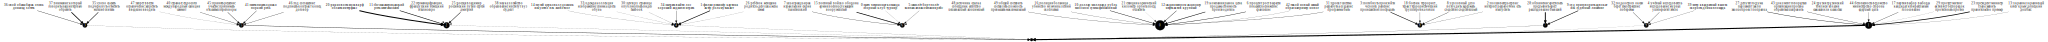

In [230]:
file.close()
file = open('topic-model-example/graphs/tree.dot', 'r')
text=file.read()
Source(text)

---

## визуализация

In [231]:
# посмотрим еще раз как каждый документ относится к тому или иному топику
topic_model.p_y_given_x

array([[9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.56913708e-03, 8.49613203e-03, 4.10159618e-02],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.56693126e-03, 9.76281994e-03, 4.13889498e-02],
       [9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.56620894e-03, 8.96125883e-03, 3.10456349e-01],
       ...,
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.56580468e-03, 9.87647398e-03, 9.90734288e-01],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.57421407e-03, 2.87857202e-02, 3.92462359e-02],
       [1.00000000e-06, 1.00000000e-06, 2.66465983e-06, ...,
        2.57602894e-03, 9.15072489e-03, 8.19656839e-02]])

In [232]:
# возьмем для примера 1й док
topic_model.p_y_given_x[0]

array([9.99999000e-01, 1.00000000e-06, 1.00000000e-06, 4.86889963e-06,
       1.00000000e-06, 2.09723974e-06, 1.05907682e-04, 2.57961863e-05,
       4.80275889e-05, 2.52735627e-04, 2.40749827e-03, 9.80959970e-01,
       4.54595902e-06, 3.70318186e-02, 1.53771530e-05, 2.14759664e-04,
       1.98299022e-04, 1.31036445e-05, 8.04088264e-04, 5.39910026e-04,
       2.66017402e-03, 8.63041958e-05, 7.94154635e-04, 2.72027435e-03,
       8.36807206e-05, 4.58265052e-01, 2.06827799e-02, 3.25252832e-04,
       9.88092801e-04, 4.58526971e-04, 9.28698684e-01, 1.13274641e-02,
       6.91662067e-04, 3.26698478e-02, 9.80460198e-01, 9.90841447e-01,
       9.99906246e-01, 4.14511905e-02, 5.83035644e-04, 6.58052924e-03,
       2.69409153e-02, 2.84087868e-02, 8.52265109e-01, 2.19124769e-01,
       4.51448980e-02, 6.24968338e-01, 3.42290452e-02, 2.56913708e-03,
       8.49613203e-03, 4.10159618e-02])

In [233]:
# тут уже без P(), а через так званое двоичное определение
topic_model.labels

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [234]:
# создаем новый датафрейм для последующих манипуляций
theta=pd.DataFrame(topic_model.p_y_given_x)

# переименуем колонки для лучшего понимания 
old_names=list(range(NUM_TOPICS))
new_names=['topic_{}'.format(i) for i in range(NUM_TOPICS)]
theta.rename(columns=dict(zip(old_names, new_names)),inplace=True)

# добавим `docID` чтобы красиво смерджить с основным датасетом
theta['docID']=[i for i in range(df.shape[0])]

print(theta.shape)
theta.head()

(699484, 51)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,docID
0,0.999999,0.000001,0.000001,0.000005,0.000001,0.000002,0.000106,0.000026,0.000048,0.000253,...,0.028409,0.852265,0.219125,0.045145,0.624968,0.034229,0.002569,0.008496,0.041016,0
1,0.000001,0.000001,0.000001,0.001996,0.000001,0.000061,0.000002,0.999999,0.000014,0.000050,...,0.010010,0.035415,0.843736,0.155703,0.044453,0.019920,0.002567,0.009763,0.041389,1
2,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,0.000012,0.000026,0.000014,0.000012,...,0.115747,0.637286,0.041147,0.011191,0.406513,0.956481,0.002566,0.008961,0.310456,2
3,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,0.000001,0.000026,0.000048,0.000050,...,0.007401,0.003166,0.051869,0.011194,0.097020,0.007169,0.002561,0.008511,0.040909,3
4,0.000001,0.999999,0.999999,0.000014,0.000009,0.000002,0.000004,0.000026,0.000014,0.000012,...,0.025461,0.686604,0.020414,0.011194,0.044457,0.155119,0.002570,0.008677,0.999999,4


In [235]:
# собственно, мерджим по `dicID`
df_join=df[['docID','year','month','date']].merge(theta, on='docID')
print(df_join.shape)
df_join.head()

(699484, 54)


,docID,year,month,date,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,0,2018,7,2018-07-11,0.999999,0.000001,0.000001,0.000005,0.000001,0.000002,...,0.026941,0.028409,0.852265,0.219125,0.045145,0.624968,0.034229,0.002569,0.008496,0.041016
1,1,2018,7,2018-07-11,0.000001,0.000001,0.000001,0.001996,0.000001,0.000061,...,0.068720,0.010010,0.035415,0.843736,0.155703,0.044453,0.019920,0.002567,0.009763,0.041389
2,2,2018,7,2018-07-11,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,...,0.003212,0.115747,0.637286,0.041147,0.011191,0.406513,0.956481,0.002566,0.008961,0.310456
3,3,2018,7,2018-07-11,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,...,0.029427,0.007401,0.003166,0.051869,0.011194,0.097020,0.007169,0.002561,0.008511,0.040909
4,4,2018,7,2018-07-11,0.000001,0.999999,0.999999,0.000014,0.000009,0.000002,...,0.001874,0.025461,0.686604,0.020414,0.011194,0.044457,0.155119,0.002570,0.008677,0.999999


In [236]:
# групируем по годам и месяцам, суммируя P()
gb = df_join.groupby(['year', 'month'])[new_names].sum()
print(gb.shape)
gb.head(10)

(228, 50)


topic_0    topic_1     topic_2     topic_3    topic_4  \
year month                                                            
1999 8       0.000017   1.785576    0.000743    6.308443   1.308122   
     9      15.963808  29.896189   44.223975  209.559638  45.380926   
     10     11.754483  23.501767   65.042891  131.229048  40.937971   
     11      7.716745  15.247118   86.423565  152.299325  46.206442   
     12     12.122698  27.685036  103.378000  201.396863  37.133961   
2000 1      10.740429  23.946622   61.172446  147.143228  36.353255   
     2      48.878289  36.511555   76.978177  202.669097  26.320516   
     3      94.190134  38.546414   93.198135  263.934619  33.181386   
     4      86.030334  30.024686   82.337597  259.894235  47.110127   
     5      72.001543  29.173524   75.556290  306.459138  35.668943   

              topic_5     topic_6    topic_7     topic_8     topic_9  \
year month                                                             
1999 8       3.179967    1.186947   0.244674    3.956874    2.714209   
     9      57.216735   53.043453  66.461790  124.233894   64.431881   
     10     51.631789   96.695248  70.667982  114.420467   87.631986   
     11     70.931534  102.480476  83.652212  136.460645  148.881099   
     12     70.993482   78.858191  67.426679  156.132365  143.153139   
2000 1      43.091157   58.480614  44.910128   96.191082   80.257099   
     2      88.007198   76.361862  92.105570  179.078816  117.187137   
     3      71.377572   96.053743  80.964246  204.043829  114.734874   
     4      86.377107   89.633788  68.828630  248.281558  117.744753   
     5      72.912239   75.892533  67.857061  241.374295  108.022751   

               ...        topic_40    topic_41    topic_42    topic_43  \
year month     ...                                                       
1999 8         ...        3.638161    8.705736    4.299821    7.381923   
     9         ...      137.093054  227.357616  163.350302  184.883057   
     10        ...      145.883345  264.075119  203.589820  236.083506   
     11        ...      200.528962  346.050730  260.530295  287.323237   
     12        ...      159.323215  364.306516  230.371819  291.124529   
2000 1         ...      122.809993  240.165450  167.777765  193.319799   
     2         ...      167.537931  303.307038  221.465144  265.719542   
     3         ...      181.804141  310.735110  235.795461  306.971926   
     4         ...      153.799498  274.910320  200.556971  264.215802   
     5         ...      133.744500  260.053004  171.700627  257.898395   

              topic_44    topic_45    topic_46   topic_47    topic_48  \
year month                                                              
1999 8        6.380952   10.390052    4.434836   1.273909    2.883334   
     9      185.625303  222.623188  111.920566  27.103532   64.979495   
     10     209.793567  297.660189  193.009904  43.870219   67.761229   
     11     258.320474  380.819202  226.984492  51.916690  103.993853   
     12     251.675924  401.282665  230.438230  41.788715  102.391749   
2000 1      171.599782  287.388239  181.167910  38.415879   79.839485   
     2      222.819775  363.941384  236.881016  44.603312   89.510619   
     3      227.034953  425.097562  218.119164  45.171533   87.185773   
     4      234.888369  386.493752  203.921745  48.731144   87.639771   
     5      229.807161  369.442529  185.074966  35.238149   87.622812   

              topic_49  
year month              
1999 8        3.950070  
     9       98.519442  
     10     136.592889  
     11     172.284806  
     12     151.274905  
2000 1      110.952810  
     2      162.511407  
     3      188.987980  
     4      173.037141  
     5      170.280981  

[10 rows x 50 columns]

In [237]:
gb.tail(8)

topic_0     topic_1     topic_2     topic_3     topic_4  \
year month                                                               
2017 12     447.797027  440.206667  451.258477  550.688182  305.713787   
2018 1      423.780961  409.109124  382.773894  511.547035  299.840591   
     2      483.699356  362.431222  441.159059  530.888319  325.242992   
     3      423.974053  355.213507  369.716168  666.427057  350.619539   
     4      399.549658  371.681100  431.266657  567.453382  368.672959   
     5      436.627592  396.066704  386.199294  598.106669  304.655757   
     6      609.605695  374.770392  342.069927  504.868242  300.609949   
     7      470.553565  228.582496  247.065400  404.977876  236.985137   

               topic_5     topic_6     topic_7     topic_8     topic_9  \
year month                                                               
2017 12     243.937524  327.655398  306.816324  513.097656  378.070153   
2018 1      295.983670  268.916919  305.556349  348.602075  276.188892   
     2      372.490377  271.278002  331.861542  454.227932  412.086331   
     3      292.070702  264.469333  220.934013  532.641703  378.522407   
     4      323.056176  284.006593  341.218899  410.085659  381.624948   
     5      325.588804  311.337462  326.710880  434.954525  366.568203   
     6      280.368287  281.126497  431.252053  390.098877  333.437440   
     7      215.951424  233.262062  188.707830  294.003049  254.619776   

               ...        topic_40     topic_41     topic_42    topic_43  \
year month     ...                                                         
2017 12        ...      455.751938   896.414043   959.176015  754.775876   
2018 1         ...      427.772807   908.510462   854.084193  649.770871   
     2         ...      455.626807   987.495027  1012.706277  706.485060   
     3         ...      577.273606  1027.509802   961.653406  825.084323   
     4         ...      586.415234  1078.919775   974.674503  893.601987   
     5         ...      609.988010  1021.098786  1000.746396  826.301735   
     6         ...      619.118137   997.201417   982.027842  734.406251   
     7         ...      437.351551   736.043196   704.326837  575.955014   

              topic_44     topic_45     topic_46    topic_47    topic_48  \
year month                                                                 
2017 12     577.200924  1148.260740  1068.226552  170.855061  275.319881   
2018 1      541.073435   953.794728  1093.095322  150.595014  269.365443   
     2      638.589259  1042.881946  1047.936017  164.069600  285.577618   
     3      741.595259  1162.225565   845.254131  169.669228  318.984613   
     4      740.378668  1153.993695   805.761971  271.344504  316.426774   
     5      748.977600  1173.771480   898.261240  228.333901  307.589042   
     6      632.929545  1107.272945   857.402390  199.859688  281.640388   
     7      490.723979   775.009549   616.005347  132.965721  214.401183   

              topic_49  
year month              
2017 12     612.399859  
2018 1      476.070585  
     2      535.335190  
     3      529.562290  
     4      462.909510  
     5      500.302167  
     6      491.598349  
     7      398.458030  

[8 rows x 50 columns]

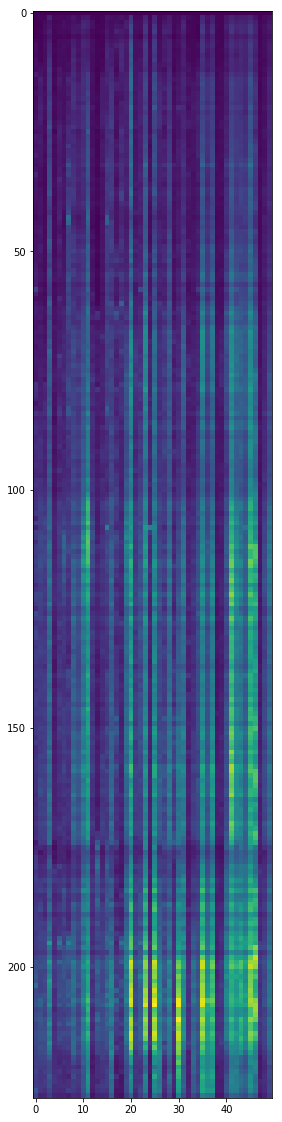

In [238]:
# отрисовываем Straightforward matrix heatmap
plt.figure(figsize=(10, 20))
plt.imshow(gb[new_names])

### рисуем через `Pygal` & `Plotly`

In [239]:
# для дальнейших графиков, готовим датасет - в каждой строке: год, месяц, P() топиков
gb_reset_index=gb.reset_index()
print(gb_reset_index.shape)
gb_reset_index.head()

(228, 52)


,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,1999,8,0.000017,1.785576,0.000743,6.308443,1.308122,3.179967,1.186947,0.244674,...,3.638161,8.705736,4.299821,7.381923,6.380952,10.390052,4.434836,1.273909,2.883334,3.950070
1,1999,9,15.963808,29.896189,44.223975,209.559638,45.380926,57.216735,53.043453,66.461790,...,137.093054,227.357616,163.350302,184.883057,185.625303,222.623188,111.920566,27.103532,64.979495,98.519442
2,1999,10,11.754483,23.501767,65.042891,131.229048,40.937971,51.631789,96.695248,70.667982,...,145.883345,264.075119,203.589820,236.083506,209.793567,297.660189,193.009904,43.870219,67.761229,136.592889
3,1999,11,7.716745,15.247118,86.423565,152.299325,46.206442,70.931534,102.480476,83.652212,...,200.528962,346.050730,260.530295,287.323237,258.320474,380.819202,226.984492,51.916690,103.993853,172.284806
4,1999,12,12.122698,27.685036,103.378000,201.396863,37.133961,70.993482,78.858191,67.426679,...,159.323215,364.306516,230.371819,291.124529,251.675924,401.282665,230.438230,41.788715,102.391749,151.274905


In [240]:
# добавляем дату
gb_reset_index['date']=gb_reset_index.apply(lambda x: prepare_date2vis(x.year,x.month),axis=1)
gb_reset_index.head(2)

,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,date
0,1999,8,0.000017,1.785576,0.000743,6.308443,1.308122,3.179967,1.186947,0.244674,...,8.705736,4.299821,7.381923,6.380952,10.390052,4.434836,1.273909,2.883334,3.950070,1999-08-11
1,1999,9,15.963808,29.896189,44.223975,209.559638,45.380926,57.216735,53.043453,66.461790,...,227.357616,163.350302,184.883057,185.625303,222.623188,111.920566,27.103532,64.979495,98.519442,1999-09-11


In [241]:
gb_reset_index.to_csv('data/corex/corex-50-333-probability.csv',index=False)

In [242]:
# файл `visualizer.py` взял с https://github.com/ods-ai-ml4sg/proj_news_viz/tree/basic_visualiser/visualization
import visualizer as tmp_vis
#pip install pygal, plotly

* ### TopicVisualizerPygal

In [243]:
%%time
pgv_pygal=tmp_vis.TopicVisualizerPygal(data=gb_reset_index.iloc[:,2:],topics=new_names)

CPU times: user 38.5 ms, sys: 60.9 ms, total: 99.4 ms
Wall time: 203 ms


In [244]:
%%time
pgv_pygal.draw()

file:///var/folders/jt/8trbfx7122q92zx4447hlz0w0000gp/T/tmp057ukxlp.html
CPU times: user 248 ms, sys: 101 ms, total: 349 ms
Wall time: 695 ms


In [245]:
%%time
pgv_pygal.save('./pygal-corex_50-333.svg')
# чтобы просмотреть, откройте этот файл у себя в браузере

CPU times: user 216 ms, sys: 12.2 ms, total: 228 ms
Wall time: 250 ms


* ### TopicVisualizerPlotly

In [246]:
%%time
pgv_plotly=tmp_vis.TopicVisualizerPlotly(data=gb_reset_index.iloc[:,2:],topics=new_names,
                                         username='your_username', api_key='your-api_key')

CPU times: user 537 ms, sys: 531 ms, total: 1.07 s
Wall time: 1.77 s


In [247]:
%%time
pgv_plotly.draw()
# можете перейти по урле ниже, чтобы посмотреть результат

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~vtrokhymenko/0 or inside your plot.ly account where it is named 'Topics over time'
CPU times: user 665 ms, sys: 383 ms, total: 1.05 s
Wall time: 4.07 s


---

# Выводы:

* довольно простая имплементация tm
* можно добавлять руками свои токены для каждого топика
* есть возможность сделать иерархическую tm, но есть пробелы у них в коде
* можно сказать что долго считает (но ночь все решает)